In [1]:
# Code for analyzing and plotting simulation profiles (run this cell first)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import os
import math
import plotly.graph_objects as go


# cm = plt.get_cmap("Accent")
# cm = cm.reversed()
# NUM_COLORS = 2
cm = plt.get_cmap("tab20").reversed()
NUM_COLORS = 7
font = {"family": "sans-serif", "weight": "normal", "size": 7}
matplotlib.rc("font", **font)
figure_width = 4
figure_height_scalar = 1.5
subplot_wspace = 10
subplot_hspace_divider = 2.8
legend_anchor = (0.5, 1.38)
legend_font_size = 7
axis_tick_size = 9
xlabel_font_size = 9
bar_width = 0.3


top_n = 5  # Number of top values to show in the plot
figure_height = 500


def plot_profile_interactive(filename, records=1):
    def plot_h(df):
        for index, row in df.iterrows():
            for col in df.columns:
                if not col.startswith("T_"):
                    row = row.drop([col])

            T_rows = [row.split("_")[1] for row in df.columns if row.startswith("T_")]
            T_rows = list(set(T_rows))
            T_rows = sorted(T_rows)
            all_data = []
            total_cycles = 0
            counter = 2
            for T_row in T_rows:
                counter = counter + 1
                all_T_row_cols = [
                    row for row in df.columns if row.startswith("T_" + T_row)
                ]
                ndf = df[all_T_row_cols].sort_values(by=0, axis=1, ascending=True)

                ndf = ndf.iloc[index]
                ndf = ndf.rename(T_row)
                ndf = ndf.to_frame().T
                ndf = ndf.T.nlargest(top_n, T_row).T  # Select top 5 values
                legends = [
                    i.replace("T_", "").replace(T_row, "S") for i in list(ndf.columns)
                ]

                total_cycles = ndf.sum(axis=1).values[0]
                if total_cycles == 0:
                    continue  # Skip if total cycles is zero
                for legend, value in zip(legends, ndf.values[0]):
                    percentage = (value / total_cycles) * 100
                    all_data.append((T_row, legend, value, percentage))
            if total_cycles == 0:
                continue  # Skip if total cycles is zero
            fig = go.Figure()

            for T_row, legend, value, percentage in all_data:
                fig.add_trace(
                    go.Bar(
                        y=[T_row],
                        x=[value],
                        orientation="h",
                        name=legend,
                        hovertext=f"{legend}: {value} ({percentage:.2f}%)",
                        hoverinfo="text",
                    )
                )

            fig.update_layout(
                title=f"Record {index}| Total Clock Cycles : {total_cycles}",
                barmode="stack",
                height=interactive_figure_height*(counter),  # Adjust the height as needed
            )

            fig.update_traces(hoverlabel=dict(font=dict(color="black")))

            fig.show()
            if index == records - 1:
                break

    df = pd.read_csv(filename, sep=",", header=0)
    print("Processing file:", filename)
    plot_h(df)


def plot_profiles_interactive(folder, show_all=False, show_x=1, records=1):
    profs = sorted(os.listdir(folder), key=lambda x: os.path.getctime(folder + x))
    profs.reverse()
    for prof in profs:
        filename = folder + prof
        plot_profile_interactive(filename, records)
        show_x -= 1
        if show_x == 0 and not show_all:
            break



def single_profile(filename, records=1):
    """
    Reads a CSV file into a pandas DataFrame and plots its contents using the plot_h function.

    Args:
        filename (str): Path to the CSV file to be processed.

    The function prints the filename being processed and generates a plot for the data.
    """

    def plot_h(df,records):
        for index, row in df.iterrows():
            for col in df.columns:
                if not col.startswith("T_"):
                    row = row.drop([col])

            T_rows = [row.split("_")[1] for row in df.columns if row.startswith("T_")]
            T_rows = list(set(T_rows))
            Tlen = T_rows.__len__()
            if row.sum() == 0:
                continue
            fig, axs = plt.subplots(
                Tlen, 1, figsize=(figure_width, Tlen * figure_height_scalar)
            )
            for id, T_row in enumerate(T_rows):
                all_T_row_cols = [row for row in df.columns if row.startswith("T_" + T_row)]
                ndf = df[all_T_row_cols]  # only first row
                ndf = ndf[ndf.columns].sort_values(by=0, axis=1, ascending=True)
                ndf = ndf.iloc[index]
                ndf = ndf.rename(T_row)
                ndf = ndf.to_frame().T
                a = ndf.sum(axis=1)
                total_cycles = a.values[0]

                ax = axs if Tlen == 1 else axs[id]
                pd.DataFrame(ndf).plot(
                    kind="barh", stacked=True, ax=ax, colormap=cm, width=bar_width
                )
                ax.set_prop_cycle(color=[cm(5 + 1.0 * i) for i in range(NUM_COLORS)])
                legends = [
                    i.replace("T_", "").replace(T_row, "S") for i in list(ndf.columns)
                ]

                ax.legend(
                    legends,
                    loc="upper left",
                    bbox_to_anchor=legend_anchor,
                    prop={"size": legend_font_size},
                    ncol=int(math.sqrt(len(legends))),
                )
                ax.set_xlabel(
                    f"Record {index} | {T_row} | Total Clock Cycles: {total_cycles}"
                )
                ax.set_xlabel(
                    ax.get_xlabel(), fontweight="normal", fontsize=xlabel_font_size
                )
                ax.set_yticklabels("")
                ax.xaxis.set_major_formatter(
                    ticker.FuncFormatter(lambda x, _: "{:,.0f}K".format(x / 1000))
                )
                ax.tick_params(axis="both", which="major", labelsize=axis_tick_size)
            plt.subplots_adjust(wspace=subplot_wspace, hspace=Tlen / subplot_hspace_divider)
            plt.show()
            if index == records - 1:
                break
        
    df = pd.read_csv(filename, sep=",", header=0)
    print("Processing file:", filename)
    plot_h(df, records=records)


def multi_profile(folder, show_all=False, show_x=3, records=1):
    """
    Processes and plots multiple profile CSV files from a specified folder.

    Args:
        folder (str): Path to the folder containing profile CSV files.
        show_all (bool, optional): If True, plot all profiles in the folder. If False, plot up to `show_x` profiles. Default is False.
        show_x (int, optional): Number of profiles to plot if `show_all` is False. Default is 3.

    The function sorts the files by creation time (most recent first), reads each CSV file,
    and generates a plot using the plot_h function. Stops after `show_x` files unless `show_all` is True.
    """
    # profs = sorted(os.listdir(folder), key=lambda x: os.path.getctime(folder + x))
    profs = [f for f in os.listdir(folder) if f.endswith(".csv")]

    # Sort by year, month, day, hour, min, second extracted from the filename
    def extract_datetime_key(x):
        # Example: vm_2025-2-27-13-0-24.csv
        parts = x.rstrip(".csv").split("_")[-1].split("-")
        # Pad month, day, hour, min, sec to 2 digits for correct sorting
        parts = [parts[0]] + [p.zfill(2) for p in parts[1:]]
        # Join as a single sortable string
        return "".join(parts)

    profs.sort(key=extract_datetime_key)
    profs.reverse()
    for prof in profs:
        filename = folder + prof
        single_profile(filename)
        show_x -= 1
        if show_x == 0 and not show_all:
            break

Processing file: ../../tensorflow/.data/vm_profs/vm_2025-2-27-13-0-24.csv


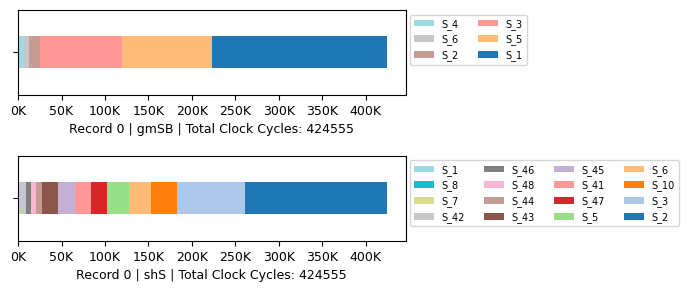

Processing file: ../../tensorflow/.data/vm_profs/vm_2025-2-25-15-54-25.csv


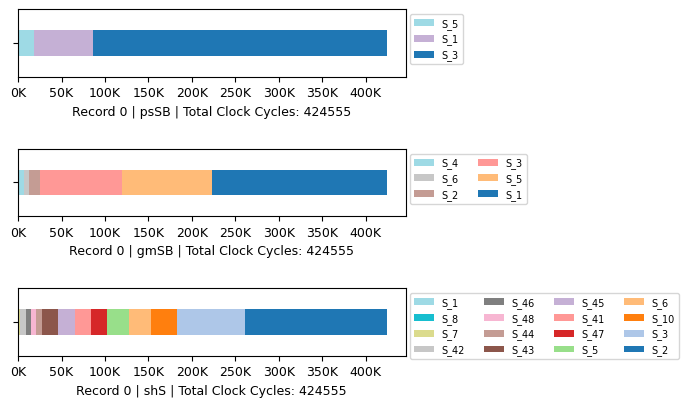

Processing file: ../../tensorflow/.data/OMNI_1_2025-7-15-12-56-14.csv


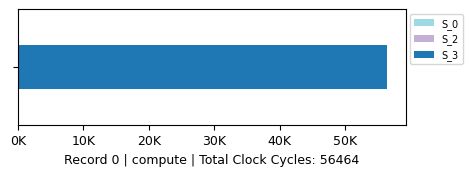

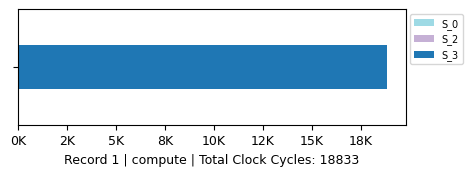

Processing file: ../../tensorflow/.data/vm_profs/vm_2024-5-3-22-21-21.csv


Processing file: ../../tensorflow/.data/vm_profs/vm_2024-10-9-10-9-53.csv


Processing file: ../../tensorflow/.data/OMNI_1_2025-7-15-12-56-14.csv


In [ ]:
# Adjust the following parameters as needed to customize the plot appearance
figure_width = 5
figure_height_scalar = 1.5
subplot_wspace = 10
subplot_hspace_divider = 2.8
legend_anchor = (1, 1)
legend_font_size = 7
axis_tick_size = 9
xlabel_font_size = 9
bar_width = 0.3

# For the interactive plot
top_n = 10  # Number of top values to show in the plot
interactive_figure_height = 75


# Use multi_profile function to process and plot profiles within the specified folder
profile_folder = "../../tensorflow/.data/vm_profs/"
# multi_profile(profile_folder, show_all=False, show_x=2, records=2) # Uncomment to process all profiles in the folder

# Use single_profile function to process and plot a single profile
# single_profile("../../tensorflow/.data/OMNI_1_2025-7-15-12-56-14.csv",records=2)  # file path to a profile CSV file


# Use plot_interactive function to plot profiles interactively
plot_profiles_interactive(profile_folder,show_all=False, show_x=2,records=2)  # file path to a profile CSV file


# Use plot_interactive function to plot profiles interactively
plot_profile_interactive("../../tensorflow/.data/OMNI_1_2025-7-15-12-56-14.csv",records=2)  # file path to a profile CSV file

